<a href="https://colab.research.google.com/github/saiku122/Kaggle/blob/master/Titanic/KaggleCompe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

★★最終課題★★</br>
〇入力データ</br>
・モデル用：train.csv</br>
・スコア用：test.csv</br>
</br>
〇出力データ</br>
・スコア付データ：</br> 
・モデル：</br>


In [175]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [176]:
#インプットファイル
file_model_name = 'train.csv'
file_test_name = 'test.csv'

In [177]:
#一度データ取り込みを実施し、取り込みデータ型を確認
df_train = pd.read_csv('./input/'+ file_model_name ,
                 header=0
)
df_test = pd.read_csv('./input/'+ file_test_name ,
                 header=0
)


In [178]:
df_train.dtypes
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [179]:
df_test.dtypes
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

■メモ</br>
PassengerIdはいったん除外</br>
Ticketは特徴量から除外</br>
Cabinも欠損値多すぎのためいったん除外する</br>
Nameは敬称でグルーピング(特徴量抽出)</br>

■方針</br>
〇欠損値補完方針</br>
・age：Pclass毎の平均値で保管する</br>
・Embarked：Sでうめる
・Fare：平均値で保管する

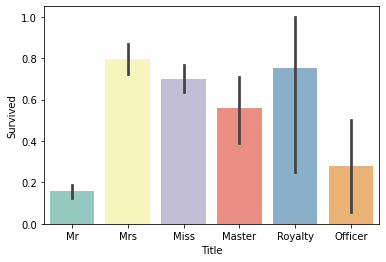

In [180]:
# Nameから敬称(Title)を抽出し、グルーピング
df_train['Title'] = df_train['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df_train['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df_train['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df_train['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df_train['Title'].replace(['Mlle'], 'Miss', inplace=True)
df_train['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df_train, palette='Set3')

In [181]:
#欠損値処理(Embarked)
df_train['Embarked']=df_train['Embarked'].fillna('S')

In [182]:
#oheカラムの定義
ohe_cols = ['Pclass',
            'Sex',
            'Embarked',
            'Title']
df_train = df_train.loc[:,['PassengerId','Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Title']]
#  モデル用データ読み込み
ID = df_train.iloc[:,0] #1列目取得
y=df_train.iloc[:,1]    #2列目の正解データを取得
X=df_train.iloc[:,2:]   #3列目以降取得
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Title           object
dtype: object

In [183]:
# one-hot encoding処理
X_ohe = pd.get_dummies(X, dummy_na=True, columns=ohe_cols)
#display(X_ohe)
X_ohe = X_ohe.dropna(axis=1,how='all')#axis=1　列
#display(X_ohe)
X_ohe_columns = X_ohe.columns.values #モデルデータの列確定

In [184]:
X_ohe.head()

,Age,SibSp,Parch,Fare,Pclass_1.0,Pclass_2.0,Pclass_3.0,Pclass_nan,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Title_nan
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,38.0,1,0,71.2833,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,26.0,0,0,7.9250,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
3,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
4,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0


In [185]:
#欠損値の置き換え
imp=SimpleImputer() #平均値で欠損値を補完
imp.fit(X_ohe)
X_ohe = pd.DataFrame(imp.transform(X_ohe),columns=X_ohe_columns) # モデルデータの列を平均値補完適用させ変数を更新

In [186]:
#特徴量抽出
selector = RFECV(estimator=RandomForestClassifier(n_estimators=100,random_state=0), step=0.05) #特徴量をRFE(主成分分析)を用いて次元削減する。(モデルはランダムフォレスト)
selector.fit(X_ohe, y) #RFEした結果を保存
X_ohe_selected = selector.transform(X_ohe) #X_oheに反映
X_ohe_selected = pd.DataFrame(X_ohe_selected, columns=X_ohe_columns[selector.support_]) #削減実行後のデータを再構成

In [187]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False])

**モデリング**

In [188]:
# set pipelines for different algorithms
pipelines = {
    'knn':
       Pipeline([('scl',StandardScaler()),
                  ('est',KNeighborsClassifier())]),
    'logistic':
        Pipeline([('scl',StandardScaler()),
                  ('est',LogisticRegression(random_state=1))]),
    'rsvc':
        Pipeline([('scl',StandardScaler()),
                  ('est',SVC(C=1.0, kernel='rbf', class_weight='balanced', random_state=1,probability = True))]),
    'lsvc':
        Pipeline([('scl',StandardScaler()),
                  ('est',SVC(C=1.0, kernel='linear', class_weight='balanced', random_state=1,probability = True))]),
    'tree':
        Pipeline([('scl',StandardScaler()),
                  ('est',DecisionTreeClassifier(random_state=1))]),
    'rf':
        Pipeline([('scl',StandardScaler()),
                  ('est',RandomForestClassifier(random_state=1))]),
    'gb':
        Pipeline([('scl',StandardScaler()),
                  ('est',GradientBoostingClassifier(random_state=1))]),
    'lgb':
        Pipeline([('scl',StandardScaler()),
                  ('lgb',lgb.LGBMClassifier())]),
    'mlp': #ニューラルネットワーク
        Pipeline([('scl',StandardScaler()),
                  ('est',MLPClassifier(hidden_layer_sizes=(3,3),
                                       max_iter=1000,
                                       random_state=1))])
}

**評価データ作成(Holdアウト法)**


In [189]:
#Holdアウト法
from sklearn.model_selection import train_test_split

In [190]:
# holdout法のテストデータ作成
X_train,X_test,y_train,y_test=train_test_split(X_ohe_selected,
                                               y,
                                               test_size=0.3,
                                               random_state=1)

In [191]:
#Holdout法を用いて評価
scores = {}
for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    scores[(pipe_name,'train')] = accuracy_score(y_train, pipeline.predict(X_train))
    scores[(pipe_name,'test')] = accuracy_score(y_test, pipeline.predict(X_test))

In [192]:
pd.Series(scores).unstack()

,test,train
gb,0.779851,0.914928
knn,0.779851,0.869984
lgb,0.772388,0.951846
logistic,0.798507,0.850722
lsvc,0.761194,0.821830
mlp,0.779851,0.831461
rf,0.761194,0.990369
rsvc,0.791045,0.858748
tree,0.753731,0.990369


**交叉検証**</br>
入力データ：X_ohe_selected</br>
　　　　　　y

In [193]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

In [194]:
#交叉検証評価

In [195]:
scores = {}
cv = KFold(5,shuffle=True,random_state=0)
for pipe_name, pipeline in pipelines.items():
  scores = cross_val_score(pipeline,X_ohe_selected,y,cv=cv)
  print(pipe_name)
  print(scores)
  print ("Mean score: {} (+/-{})".format( np.mean (scores), sem(scores)))

knn
[0.80446927 0.80337079 0.83146067 0.81460674 0.80337079]
Mean score: 0.8114556525014123 (+/-0.00542987043087707)
logistic
[0.81564246 0.81460674 0.8258427  0.84831461 0.83146067]
Mean score: 0.8271734354403364 (+/-0.006156239269037916)
rsvc
[0.81564246 0.8258427  0.80337079 0.79775281 0.85393258]
Mean score: 0.8193082669010107 (+/-0.009933834421011516)
lsvc
[0.7877095  0.80337079 0.79213483 0.82022472 0.83707865]
Mean score: 0.8081036971941498 (+/-0.009164594015175853)
tree
[0.75418994 0.80337079 0.78089888 0.76966292 0.75842697]
Mean score: 0.7733098989391751 (+/-0.008836357684024822)
rf
[0.82122905 0.79775281 0.8258427  0.81460674 0.78651685]
Mean score: 0.809189630280585 (+/-0.007404299480910666)
gb
[0.84916201 0.80898876 0.85393258 0.8258427  0.80337079]
Mean score: 0.8282593685267716 (+/-0.010229057852032517)
lgb
[0.82681564 0.78651685 0.84831461 0.79775281 0.79775281]
Mean score: 0.8114305442219572 (+/-0.011384173579448294)
mlp
[0.81005587 0.81460674 0.7752809  0.83707865 0.8

In [196]:
#モデル保存
for pipe_name, pipeline in pipelines.items():
  filename=pipe_name + '.joblib'
  joblib.dump('./output/'+ pipe_name, filename)

テストデータの加工

In [197]:
# Nameから敬称(Title)を抽出し、グルーピング
df_test['Title'] = df_test['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df_test['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df_test['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df_test['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df_test['Title'].replace(['Mlle'], 'Miss', inplace=True)
df_test['Title'].replace(['Jonkheer'], 'Master', inplace=True)

In [198]:
df_test['Embarked']=df_test['Embarked'].fillna('S')

In [199]:
df_test = df_test.loc[:,['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Title']]
#  モデル用データ読み込み
ID_s = df_test.iloc[:,0] #1列目取得
X_s=df_test.iloc[:,1:]   #2列目以降取得

In [200]:
# one-hot encoding処理
X_ohe_s = pd.get_dummies(X_s, dummy_na=True, columns=ohe_cols)
#display(X_ohe)
X_ohe_s = X_ohe_s.dropna(axis=1,how='all')#axis=1　列
#display(X_ohe)
X_ohe_columns_s = X_ohe_s.columns.values #テストデータの仮確定

※ここで列整合性が合致していることを確認

In [201]:
#列の整合性チェック
cols_model = set(X_ohe.columns.values)
cols_score = set(X_ohe_s.columns.values)

diff1 = cols_model - cols_score
print('モデルのみに存在する項目: %s' % diff1)

diff2 = cols_score - cols_model
print('スコアのみに存在する項目: %s' % diff2)

モデルのみに存在する項目: set()
スコアのみに存在する項目: set()


In [202]:
#ソート順の統一
X_ohe_s2 = X_ohe_s.reindex(X_ohe.columns.values,axis=1)
X_ohe_s2.head(3)

,Age,SibSp,Parch,Fare,Pclass_1.0,Pclass_2.0,Pclass_3.0,Pclass_nan,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Title_nan
0,34.5,0,0,7.8292,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
1,47.0,1,0,7.0000,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2,62.0,0,0,9.6875,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0


In [203]:
#欠損値処理
X_ohe_s3 = pd.DataFrame(imp.transform(X_ohe_s2),columns=X_ohe_columns)

In [204]:
#RFE適用後の列名のみテストデータから抽出
X_ohe_selected_s=X_ohe_s3.loc[:, X_ohe_columns[selector.support_]]

In [205]:
X_ohe_selected_s

,Age,SibSp,Parch,Fare,Pclass_1.0,Pclass_2.0,Pclass_3.0,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,34.500000,0.0,0.0,7.8292,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,47.000000,1.0,0.0,7.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,62.000000,0.0,0.0,9.6875,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,27.000000,0.0,0.0,8.6625,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,22.000000,1.0,1.0,12.2875,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,29.699118,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
414,39.000000,0.0,0.0,108.9000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
415,38.500000,0.0,0.0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
416,29.699118,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


今回は交叉検証およびholdoutからlogistic回帰を採用

In [206]:
tgt_model_name = 'logistic'

for pipe_name, pipeline in pipelines.items():
  if pipe_name == tgt_model_name:
    score=pd.DataFrame(pipeline.predict(X_ohe_selected_s), columns=['Survived'])



In [207]:
ans=pd.concat([ID_s, score], axis=1)

In [208]:
ans.to_csv('./output/gender_submission.csv', index=False)